In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab
import torch
import sys
import time
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from RBM import RBM
from scipy.integrate import simps
from scipy import stats
import h5py

device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [2]:
# w_hat : nDim x nb_point
# V : matrice de projection
def TMCSampleND(v, w_hat, N, V, it_mcmc=100, it_mean=50, ß=1):
    #print("Initialisation")
    vtab = torch.zeros(v.shape, device=device)
    v_curr = v
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = (torch.mm(v_curr.T, V)*norm)[:,:w_hat.shape[0]]
    index = torch.randperm(v_curr.shape[0])
    for t in range(it_mcmc):
        #print('init it')
        print(t)
        h_curr, _ = myRBM.SampleHiddens01(v_curr)
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)) # Nv x Ns
        w_next = w_curr.clone()
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
        for idx in range(v_curr.shape[0]):
            s = time.time()
            i = idx
            v_next[i,:] = 1-v_curr[i,:]
            for j in range(w_next.shape[1]):
                w_next[:,j] += ((2*v_next[i,:]-1)*V[i,j]*norm)
                
            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i,:]-1)*h_i[i,:])-(N/2)*(torch.sum((w_hat.T-w_next)**2, dim=1)-torch.sum((w_hat.T-w_curr)**2, dim=1))

            tir = torch.rand(v_curr.shape[1],1, device = torch.device("cuda")).squeeze()
            prob = torch.exp(ΔE).squeeze()
            v_curr[i,:] = torch.where(tir<prob, v_next[i,:], v_curr[i,:])
            v_next[i,:] = torch.where(tir<prob, v_next[i,:], 1-v_next[i,:])
            neg_index = torch.ones(w_curr.shape[0], dtype = bool)
            index = torch.where(tir<prob)[0]
            neg_index[index] = False
            w_curr[index,:]=  w_next[index, :]
            w_next[neg_index,:] =  w_curr[neg_index,:]
            #print(time.time()-s)
        if (t>= (it_mcmc-it_mean)):
            vtab += v_curr
    vtab = vtab*(1/it_mean)
    vtab = vtab.reshape(myRBM.Nv, nb_point, nb_chain)
    v_curr = v_curr.reshape(myRBM.Nv, nb_point, nb_chain)
    h_curr = h_curr.reshape(myRBM.Nh, nb_point, nb_chain)
    return v_curr, h_curr, vtab

def TMCSample(v, w_hat, N, V, it_mcmc=100, it_mean=50, ß=1):
    #print("Initialisation")
    #s = time.time()
    vtab = torch.zeros(v.shape, device = device)
    v_curr = v
    #V = V
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = (torch.mv(v_curr.T, V)*norm)
    
    index = torch.randperm(v_curr.shape[0])
    #print(time.time()-s)
    #print("IT MCMC")
    s = time.time()

    for t in range(it_mcmc):
        #print('init it')
        print(t)
        h_curr, _ = myRBM.SampleHiddens01(v_curr)
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)) # Nv x Ns
        w_next = w_curr.clone()
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
        for idx in range(v_curr.shape[0]):
            #print('upd comp')
            s = time.time()
            i = idx
            v_next[i,:] = 1-v_curr[i,:]
            w_next += ((2*v_next[i,:]-1)*V[i]*norm)

            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i,:]-1)*h_i[i,:])-(N/2)*((w_hat-w_next)**2-(w_hat-w_curr)**2)

            tir = torch.rand(v_curr.shape[1],1, device = torch.device("cuda")).squeeze()
            prob = torch.exp(ΔE).squeeze()
            v_curr[i,:] = torch.where(tir<prob, v_next[i,:], v_curr[i,:])
            v_next[i,:] = torch.where(tir<prob, v_next[i,:], 1-v_next[i,:])
            w_curr = torch.where(tir<prob, w_next, w_curr)
            w_next = torch.where(tir<prob, w_next, w_curr)
            #print(time.time()-s)
        if (t>= (it_mcmc-it_mean)):
            vtab += v_curr
    print(time.time()-s)

    vtab = vtab*(1/it_mean)    
    return v_curr, h_curr, vtab

In [3]:
data = torch.tensor(np.genfromtxt('../dataset/data_2d.dat'), device = device, dtype = dtype)

data = (data+1)/2

RuntimeError: CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect. For debugging consider passing CUDA_LAUNCH_BLOCKING=1. CUDA error: out of memory

In [ ]:
f = h5py.File("../model/TMC2D/AllParametersTMC2DRBM_NGibbs_50_Nh100_Nv1000_Nmb200_Nepoch100_lr_0.01_N20000_Npoint2500_Nchain10_phase2.h5", 'r')
alltimes = np.array(f['alltime'])
alltimes = []
for t in f['alltime'][:]:
    if 'W'+str(t) in f:
        alltimes.append(t)
t = alltimes[-1]
        
lr = 0.01
l2 = 0
NGibbs = 10
annSteps = 0
mb_s = 500
num_pcd = 500
ep_max = 100
myRBM = RBM(num_visible=1,
				num_hidden=1,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)

myRBM.W = torch.tensor(f['W'+str(t)], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias'+str(t)], device = myRBM.device)
myRBM.vbias = torch.tensor(f['vbias'+str(t)], device = myRBM.device)
_, _, V = torch.svd(myRBM.W)
myRBM.Nh = myRBM.W.shape[0]
myRBM.Nv = myRBM.W.shape[1]
if torch.mean(V[:,0])<0:
    V = -V
    
V_g = V
proj_data =torch.mm(data, V_g).cpu()/myRBM.Nv**.5

f.close()


In [ ]:
nb_chain = 10 # Nb de chaines pour chaque w_hat
it_mcmc = 150 # Nb it_mcmc pour chaque chaine
it_mean = 100 # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 20000 # Contrainte
nb_point = 50 # Nb de points de discrétisation pour w_hat
width_plus = .6
nDim = 2

limits = torch.zeros((2, nDim))
for i in range(nDim):
    limits[0, i] = proj_data[:,i].min()-width_plus
    limits[1, i] = proj_data[:,i].max()+width_plus

xmin = proj_data[:,0].min()-width_plus
xmax = proj_data[:,0].max()+width_plus
ymin = proj_data[:,1].min()-width_plus
ymax = proj_data[:,1].max()+width_plus

In [ ]:
start = torch.bernoulli(torch.rand(myRBM.Nv, nb_chain*nb_point, device = device))
V0 = V[:,0]
# w_hat = torch.dot(start.T, V)[0:,]
w_hat_b = torch.linspace(xmin, xmax, steps =nb_point, device = device)
w_hat = torch.zeros(nb_chain*nb_point, device = device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[i*nb_chain+j] = w_hat_b[i]
tmpv, tmph, vtab = TMCSample(start, w_hat, N, V0, it_mcmc = it_mcmc, it_mean=it_mean)

y = np.array(torch.mm(vtab.T, V0.unsqueeze(1)).cpu().squeeze())/myRBM.Nv**0.5
newy = np.array([np.mean(y[i*nb_chain:i*nb_chain+nb_chain]) for i in range(nb_point)])
w_hat = w_hat.cpu().numpy()
w_hat_b = w_hat_b.cpu().numpy()
res=np.zeros(len(w_hat_b)-1)
for i in range(1,len(w_hat_b)):
    res[i-1] = simps(newy[:i]-w_hat_b[:i], w_hat_b[:i])
const = simps(np.exp(N*res-np.max(N*res)), w_hat_b[:-1])
p_m_1D = torch.tensor(np.exp(N*res-np.max(N*res)) /
                    const, device=device)

In [ ]:
nb_chain = 15 # Nb de chaines pour chaque w_hat
it_mcmc = 70 # Nb it_mcmc pour chaque chaine
it_mean = 20 # Nb it considérée pour la moyenne temporelle de chaque chaine
nb_point_dim = torch.tensor([50,50]) # -> doit avoir autant de terme que la valeur de nDim
N = 10000 # Contrainte
#nb_point_x = 125 # Nb de points de discrétisation pour w_hat
#nb_point_y = 125

nb_point = nb_point_dim.prod()

In [ ]:
x_grid = np.linspace(limits[0,0], limits[1,0], nb_point_dim[0])
x_grid = np.array([x_grid for i in range(nb_point_dim[1])])
x_grid = x_grid.reshape(nb_point)
y_grid = []
y_d = np.linspace(limits[0,1], limits[1,1], nb_point_dim[1])
for i in range(nb_point_dim[1]):
    for j in range(nb_point_dim[0]):
        y_grid.append(y_d[i])
grid = torch.tensor([x_grid, y_grid], device = device, dtype = dtype)
start = torch.bernoulli(torch.rand(myRBM.Nv, nb_chain*nb_point, device = device))
# w_hat = torch.dot(start.T, V)[0:,]
w_hat_b = grid
w_hat = torch.zeros((2, nb_chain*nb_point), device = device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[:,i*nb_chain+j] = w_hat_b[:,i]
tmpv, tmph, vtab = TMCSampleND(start, w_hat, N, V_g, it_mcmc = it_mcmc, it_mean=it_mean)

newy = torch.mm(torch.mean(vtab, dim = 2).T, V_g)[:,:nDim]/myRBM.Nv**0.5

grad_pot = newy.T-w_hat_b
square = torch.zeros(2, nb_point_dim[0], nb_point_dim[1])
w_hat_tmp = np.zeros((2, nb_point_dim[0], nb_point_dim[1]))
for i in range(0,grad_pot.shape[1], nb_point_dim[0]):
        #print(\"I : \", i/nb_point_x)
        #print(\"s : \", (i*nb_point_x))
        #print(\"e : \", (i*nb_point_x+nb_point_x))
        w_hat_tmp[:,:,int(i/nb_point_dim[0])] = w_hat_b[:, i:(i+nb_point_dim[0])].cpu().numpy()
        #print(w_hat_b[:, i:(i+nb_point_dim[0])].cpu().numpy())
        square[:,:, int(i/nb_point_dim[0])] = grad_pot[:,i:(i+nb_point_dim[0])]
#square = grad_pot.reshape(2,nb_point_dim[0], nb_point_dim[1])
w_hat_dim = []
for i in range(nDim):
    w_hat_dim.append(np.linspace(limits[0,i], limits[1,i], nb_point_dim[i]))

res_x = np.zeros(nb_point_dim[0])
for i in range(nb_point_dim[0]):
    res_x[i] = simps(square[0][:(i+1),0].cpu().numpy(), w_hat_tmp[0,:(i+1),0])
res_y = np.zeros((nb_point_dim[0], nb_point_dim[1]))
for i in range(nb_point_dim[0]):
    for j in range(nb_point_dim[1]):
        res_y[i,j] = simps(square[1][i,:(j+1)].cpu().numpy(), w_hat_tmp[1,i,:(j+1)])

pot = np.expand_dims(res_x, 1).repeat(nb_point_dim[1],1) + res_y    
res = np.exp(N*(pot-np.max(pot)))
#LE CALCUL DE LA CONSTANTE EST CORRECT
const = np.zeros(res.shape[0])
for i in range(res.shape[0]):
    const[i-1] = simps(res[:,i], w_hat_tmp[1, i, :])
const = simps(const, w_hat_tmp[0,:,0])
p_m = res/const

<ipython-input-15-7fb7db069084>:1: RuntimeWarning: divide by zero encountered in log
  plt.contour(w_hat_tmp[0],w_hat_tmp[1], np.log(p_m), 10)


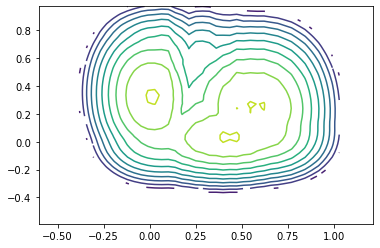

In [15]:
plt.contour(w_hat_tmp[0],w_hat_tmp[1], np.log(p_m), 10)


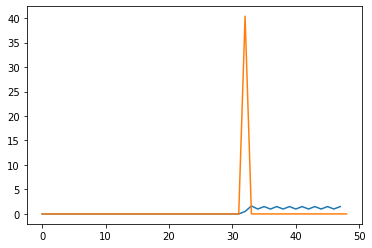

In [24]:
p_m_1D = torch.tensor(np.exp(N*res-np.max(N*res)) /
                    const, device=device).cpu().numpy()
cdf_1D = np.zeros(len(p_m_1D)-1)
for i in range(1,len(p_m_1D)):
    cdf_1D[i-1] = simps(p_m_1D[:i], w_hat_b[:i])
plt.plot(cdf_1D)
plt.plot(p_m_1D)

In [13]:
%debug

> /home/nicolas/anaconda3/lib/python3.8/site-packages/scipy/integrate/_quadrature.py(468)simps()
    466                              "same as y.")
    467         if x.shape[axis] != N:
--> 468             raise ValueError("If given, length of x along axis must be the "
    469                              "same as y.")
    470     if N % 2 == 0:



ipdb>  u


> <ipython-input-12-fe08331e5707>(4)<module>()
      1 x_1D = np.linspace(limits[0,0], limits[1,0], nb_point_dim[0])
      2 cdf_1D = np.zeros(len(p_m_1D)-1)
      3 for i in range(1,len(p_m_1D)):
----> 4     cdf_1D[i-1] = simps(p_m_1D[:i], x_1D[:i])
      5 plt.plot(cdf_1D)



ipdb>  p_m_1D[:i].shape


(51,)


ipdb>  x_1D[:i].shape


(50,)


ipdb>  x_1D.shape


(50,)


ipdb>  p_m_1D.shape


(2499,)


ipdb>  exit


In [85]:
yyy = np.linspace(limits[0,1], limits[1,1], nb_point_dim[1])
xxx = np.linspace(limits[0,0], limits[1,0], nb_point_dim[0])
cdf_x = np.zeros(p_m.shape[0])
for i in range(p_m.shape[0]):
    cdf_x[i] = simps(p_m[:(i+1),0],  xxx[:(i+1)])
cdf_y = np.zeros((p_m.shape[0], p_m.shape[1]))
for i in range(p_m.shape[0]):
    for j in range(p_m.shape[1]):
        cdf_y[i,j] = simps(p_m[i,:(j+1)], yyy[:(j+1)])
cdf = np.expand_dims(cdf_x, 1).repeat(nb_point_dim[1],1) + cdf_y    


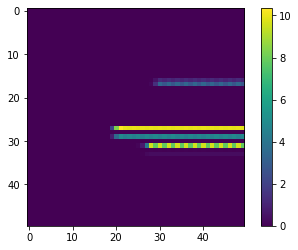

In [92]:
plt.imshow(cdf)
plt.colorbar()

In [87]:
def sample2D(cdf, n_sample):
    sample = torch.rand(n_sample)
    res = torch.zeros(n_sample,2, dtype = int)
    for k in range(n_sample):
        for i in range(cdf.shape[0]-1):
            for j in range(cdf.shape[1]-1):
                if cdf[i+1, j+1]>sample[k]:
                    res[k,0] = xxx[i]
                    res[k,1] = j
                    break
    return res
    

In [88]:
s = sample2D(cdf, 100)


In [ ]:
plt.hist(s.cpu().numpy(), bins = 100);
plt.plot(p_m)

In [ ]:
plt.plot(p_m)

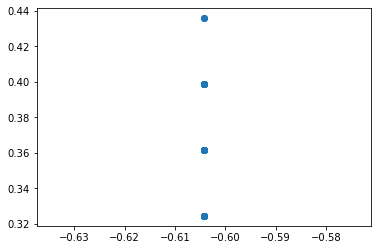

In [89]:

absc = []
ordo = []
for i in range(s.shape[0]):
    absc.append(xxx[s[i,0]])
    ordo.append(xxx[s[i,1]])
plt.scatter(absc, ordo)

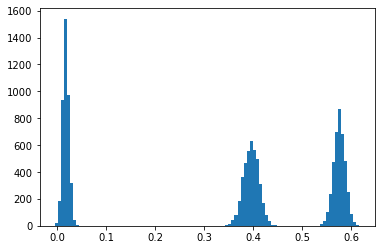

In [96]:
plt.hist(proj_data[:,0].cpu().numpy(), bins = 100);